# [Computational Social Science]
## 5-3 Text Feature Engineering and Classification - Solutions

In this lab we will use the techniques we covered so far to engineer text features and train a classification algorithm.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. If you have already created a virtual enviornment, you can run the following command to activate it. <br>
`conda activate <virtual_env_name>` <br>
For example, if your virtual environment was named `css_lab`, run the following command. <br>
`conda activate css_lab` <br>
To deactivate your virtual environment after you are done working with the lab, run the following command. <br>
`conda deactivate`

In [1]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-14 13:59:11.070710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

<img src = "../../images/cfpb logo.png"  />

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). Picking up from where we left off last time, we'll focus on predicting whether a consumer complaint narrative is talking about a "checkings or savings account" issue or a "student loan" issue.

In [2]:
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000]

## Text Preprocessing

Before we do any feature engineering or classification, we should first preprocess our text. Let's start by adding custom stop words and defining our custom `rem_punc_stop()` function:

In [3]:

STOP_WORDS = STOP_WORDS.union({"XX", "XXXX","XXXXXXXX"})


In [4]:
def rem_punc_stop(text):
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in STOP_WORDS]
    
    return no_punc

Now let's go ahead and apply our function to the consumer complaint narratives. Notice how the `rem_punc_stop()` function returns a list, but we can collapse our tokens back into strings with the `join()` string method.

In [5]:
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))
cfpb['tokens']

99       I lost card lunch run break lunch realized nt ...
234      In response answer dated You stated USAA utili...
332      On XXXX2020 wife I opened business account Nav...
346      I signed opened citibank checking account late...
397      On XXXX2020 CARES Act signed federal law indic...
                               ...                        
42908    My student loans serviced Navient Circa 2012 N...
43000    On 2019 I debit card purchase denied After inv...
43048    On I received fraud check fake company contact...
43049    I m filing complaint AscendiumXXXX   Departmen...
43054    I believe I taken advantage Wells Fargo Bank c...
Name: tokens, Length: 1000, dtype: object

## Wrap up EDA

We've already explored several exploratory data analysis techniques. There are many different ways to explore text data that we haven't covered, but let's take a look at one last basic tool: visualizing n-grams.  

In [6]:
# Initialize the BOW countervectorizer
## Notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), ngram_range=(2,3))
ngrams = countvec.fit_transform(cfpb['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


In [7]:
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

,ngrams,freq
0,wells fargo,337
1,checking account,303
2,debit card,208
3,bank america,198
4,customer service,171


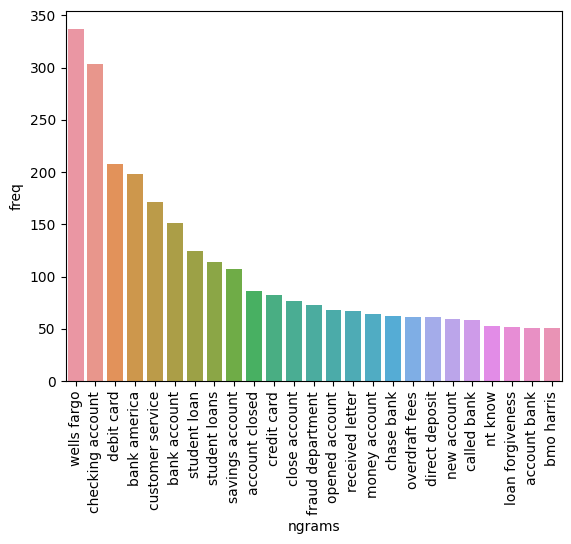

In [8]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

## Challenge: N-Grams

Adjust the code above to visualize the most popular unigrams and 4-grams. What is the tradeoff involved with increasing n?

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


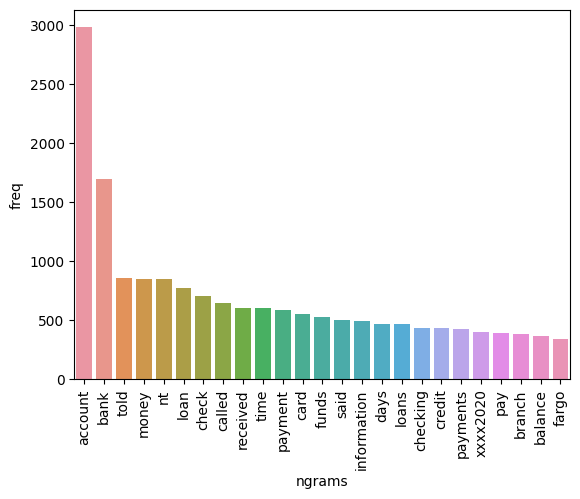

In [9]:
countvec = CountVectorizer(stop_words=list(STOP_WORDS), ngram_range=(1,1))
ngrams = countvec.fit_transform(cfpb['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


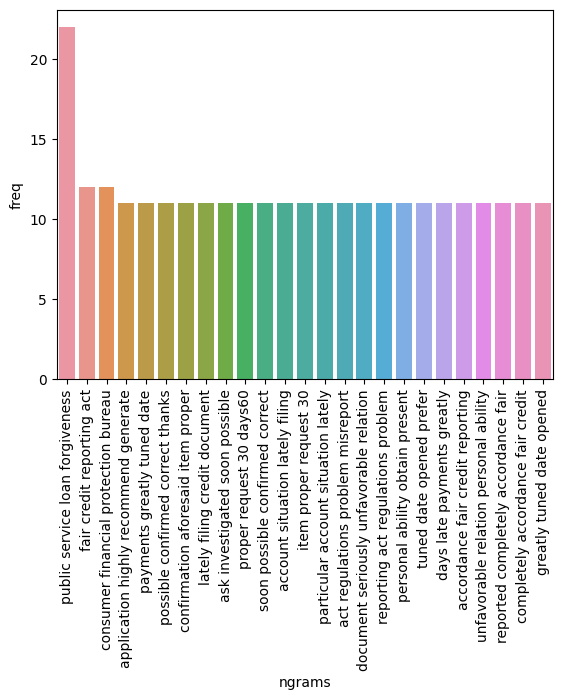

In [10]:
countvec = CountVectorizer(stop_words=list(STOP_WORDS), ngram_range=(4,4))
ngrams = countvec.fit_transform(cfpb['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**Answer**: Increasing n does pick up much more unique phrases (like 'public service loan forgiveness'), but the overall frequencies are quite low and potentially unhelpful. At the extreme, you could imagine making a n-gram that was as long as an entire document - it would perfectly classify that document but nothing else. This is similar to the bias-variance tradeoff and the dangers with overfitting.

## Feature Engineering

Last time, we saw some techniques for exploring the text of our data. Specifically, we saw how to find the length of our text and word counts:

In [11]:
cfpb['complaint_len'] = cfpb['tokens'].apply(len)
cfpb['complaint_len']

99        358
234       488
332       234
346       196
397      1155
         ... 
42908     567
43000     690
43048     992
43049    1016
43054     222
Name: complaint_len, Length: 1000, dtype: int64

In [12]:
cfpb['word_count'] = cfpb['tokens'].apply(lambda x: len(str(x).split()))
cfpb['word_count']

99        60
234       73
332       36
346       31
397      145
        ... 
42908     76
43000    108
43048    165
43049    152
43054     35
Name: word_count, Length: 1000, dtype: int64

We also covered subjectivity and sentiment:

In [13]:
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cfpb['subjectivity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

### Build a Dictionary

Before we continue, let's take the top 25 n-grams we found earlier and turn them into their own dataframe. We'll return to these later.

In [14]:
countvec = CountVectorizer(stop_words=list(STOP_WORDS), ngram_range=(2,3))
ngrams = countvec.fit_transform(cfpb['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


,wells fargo,checking account,debit card,bank america,customer service,bank account,student loan,student loans,savings account,account closed,...,money account,chase bank,overdraft fees,direct deposit,new account,called bank,nt know,loan forgiveness,account bank,bmo harris
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Challenge: Topic Modeling

Using the code we went over from the last lab, make a dataframe with 5 LDA generated topics. Then, create a topic model using [Non-Negative Matrix Factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) and print out the words associated with the first 5 topics. NMF is another algorithm that is frequently used for topic modeling. Do you get similar topics as with your LDA topics? 

In [15]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [16]:
X = cfpb['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(np.asarray(dense_matrix))



tf_feature_names = tf.get_feature_names_out()
print_top_words(lda, tf_feature_names, 20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Topic #0:
   account bank 

  loan money nt check told 
  card loans payment funds called received xxxx2020 time payments said

Topic #1:
hsbc delta 37000 acccounts wsfs waves compromised horizon ombudsmen venue disaster onaround pod firstbank pr firstbankpr plc cds garnishments multiple

Topic #2:
weekends aplied numbers expand brinks mastercard 4x continuous keybank hours cds structuring immoral prepaid od georgia cb synovus tryed beat

Topic #3:
ozk barrow 42000 bird blue pymt wrongdoings voted warnings alliant barrows reneging expects threatens traffic la withdrwl trailer cheats ample

Topic #4:
credit lately relation unfavorable prefer misreport days120 days60 tuned aforesaid recommend generate particular seriously highly accordance greatly item present regulations



In [17]:
X = cfpb['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
nmf = NMF(n_components=5, init='random', random_state=0)
nmf = nmf.fit(np.asarray(dense_matrix))



tf_feature_names = tf.get_feature_names_out()
print_top_words(nmf, tf_feature_names, 20)

nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Topic #0:
fargo wells    claim complaint mediation card information 

  removed xxxx2019 reply charge cfpb 
  charges investigation resolution letter account

Topic #1:
loan loans    navient payments payment student interest years 

  repayment program paid forgiveness school plan income fedloan pay education

Topic #2:
credit prefer tuned days60 days120 misreport unfavorable aforesaid lately recommend relation generate particular seriously highly item accordance greatly present regulations

Topic #3:
account bank check    money nt told card funds xxxx2020 branch said 

  chase called america closed 
  fees fraud

Topic #4:
bonus    account citibank days citi checking opened offer requirements receive savings opening 

  new received 60 direct promotion 90



**Answer**: Somewhat - topic 1 from LDA is similar to topic 2 from NMF for example.

## Classification

Now we're ready to move to classification! We are going to examine how different featurization techniques compare. Create a list with the following:
 * Text Engineered Features
 * Text Engineered Features + Topic Model
 * Non-Text Features only
 * Non-Text Features + Text Engineered Features
 * Tf-idf
 * Non-Text Features + tf-idf
 * Non-Text Features + Top 25 n-gram

You'll need to use pandas to create and .`join()` these different dataframes together. Also be sure to use `reset_index()` as necessary. Once you've created each of these dataframes (or arrays!) you should loop through all of them, train a supervised learning algorithm (like logistic regression or a decision tree classifier), and plot confusion matrices. Once you do this, think about which featurization technique worked the best, and whether combining text and non-text features was helpful. For now, don't worry about hyperparameter tuning or feature selection, though you would do these in practice.

In [18]:
cfpb.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'tokens',
       'complaint_len', 'word_count', 'polarity', 'subjectivity'],
      dtype='object')

In [19]:
# Engineered Text Features
engineered_features = cfpb[['complaint_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
non_text_features = cfpb[['Company public response', 'Company',
       'State', 'Consumer consent provided?','Submitted via', 'Company response to consumer',
       'Timely response?']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names_out())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

In [20]:
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features']

lb_style = LabelBinarizer()
y = cfpb['Product_binary'] = lb_style.fit_transform(cfpb["Product"])

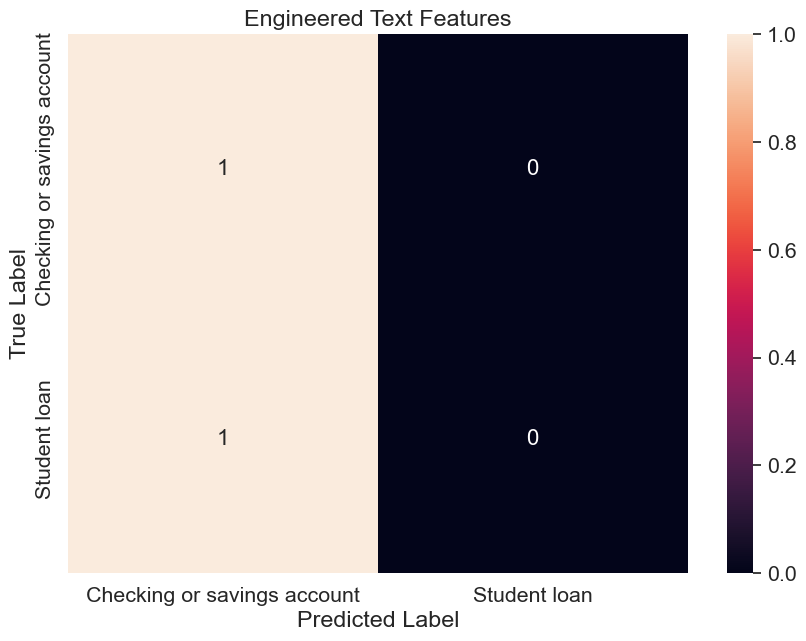

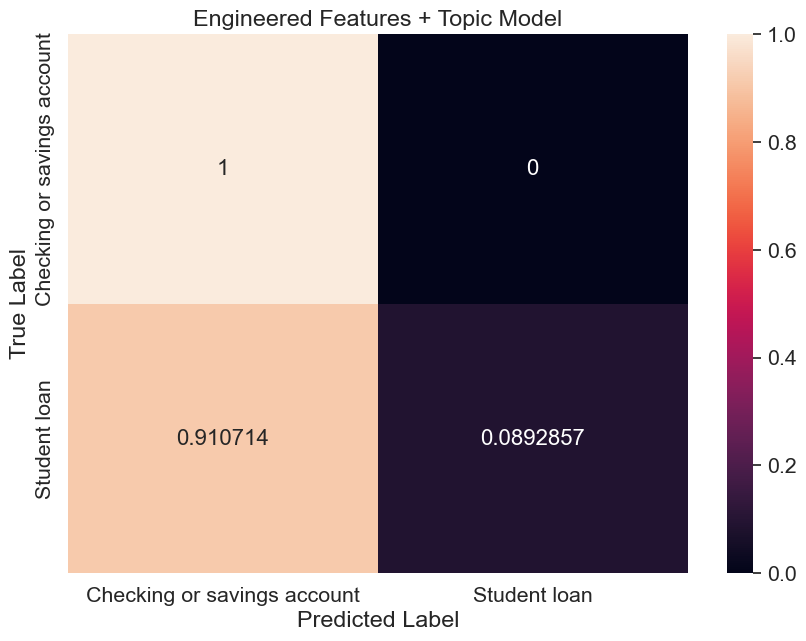

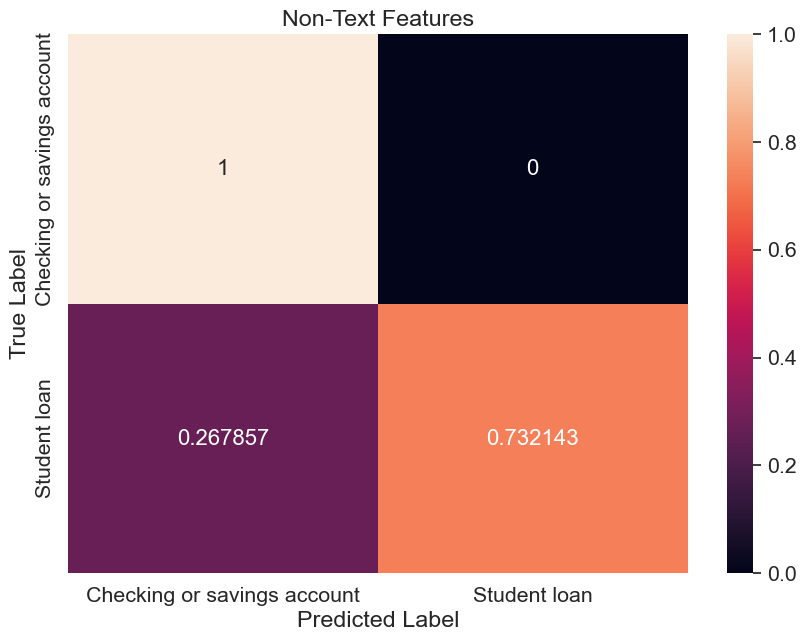

/Users/prashant/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


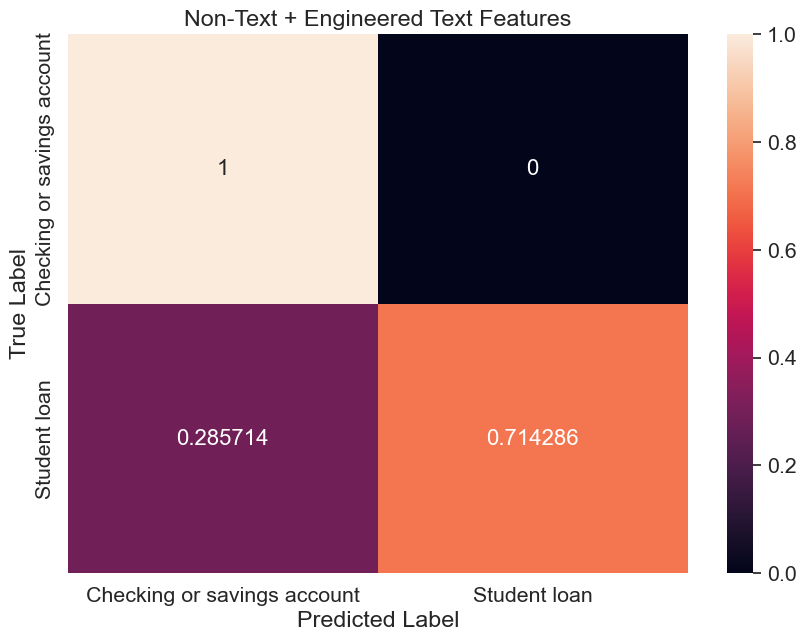

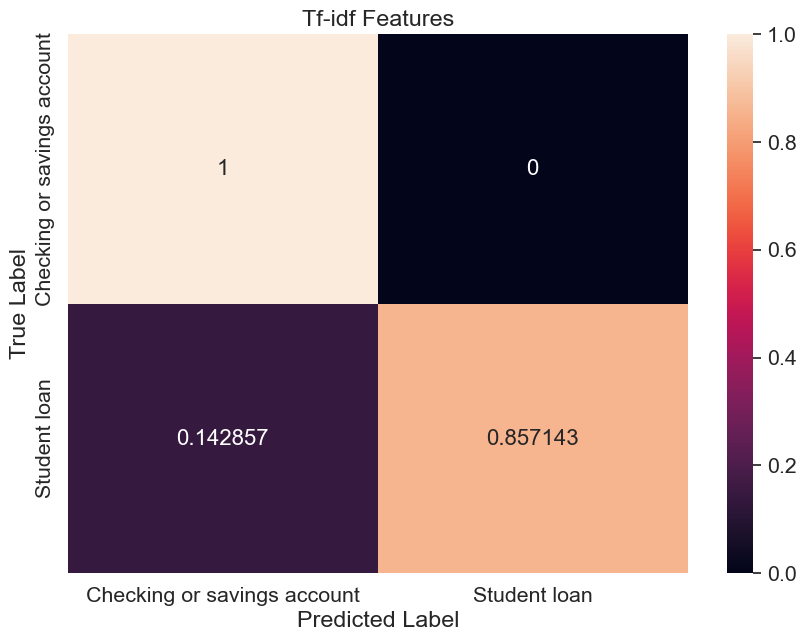

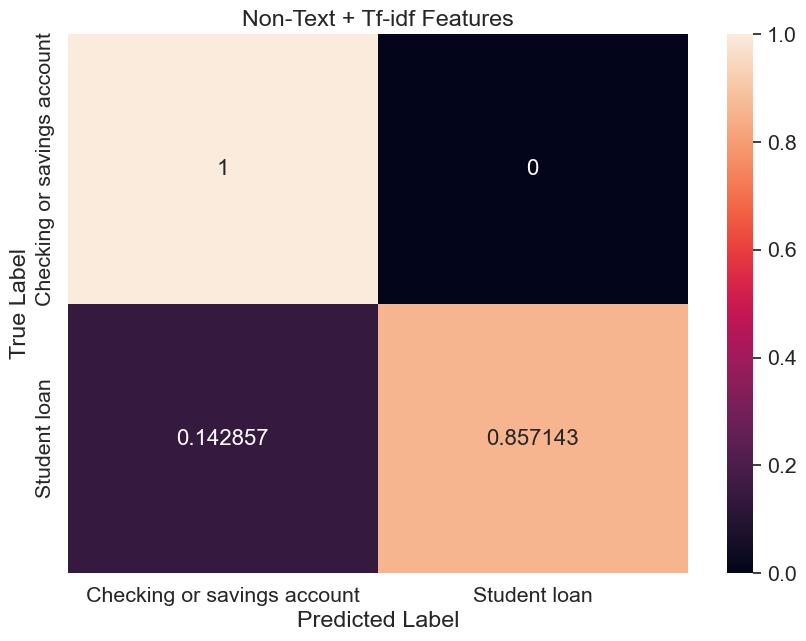

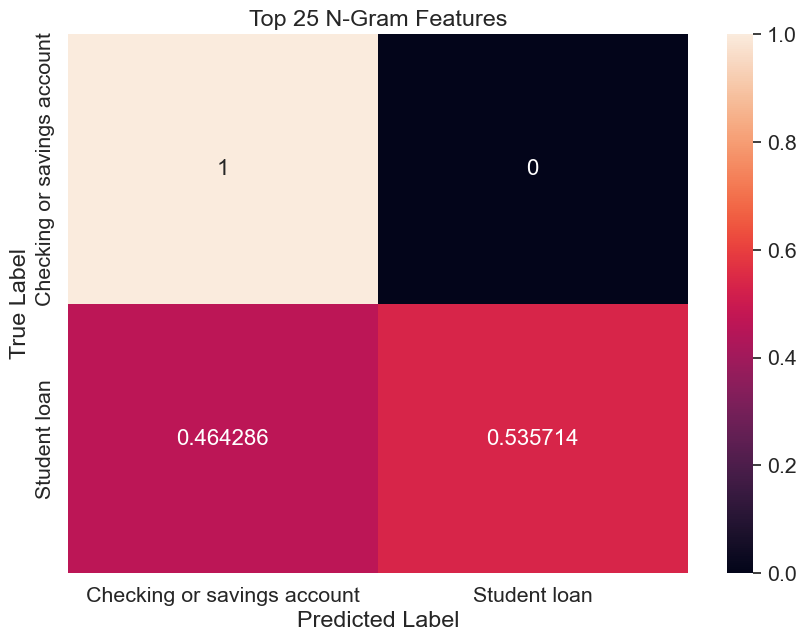

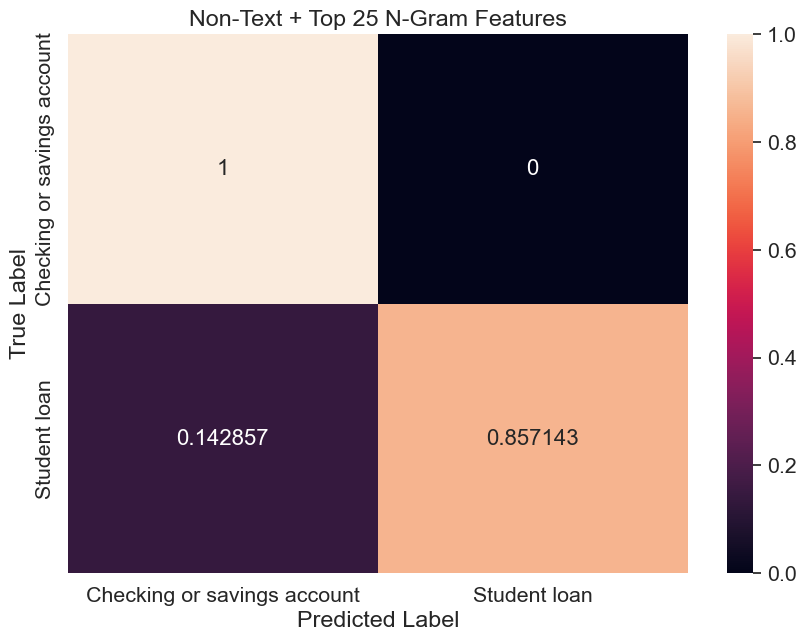

In [21]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    dataframe.columns = dataframe.columns.astype(str) # changing column names to strings because some are integer
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Checking or savings account", 1: "Student loan"})
    df_cm.index = ["Checking or savings account", "Student loan"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion

In general, combing text with non-text features will improve a classifier's performance. However this isn't automatic - in some cases you can actually degrade a classifier's performance by adding in more features. In this case, our engineered features were too quick to predict "checking or savings account" and our tf-idf alone outperformed tf-idf + non-text features. However, non-text features + n-grams was tied with tf-idf alone! We might prefer the former approach because it is computationally cheaper, and likely easier to explain.

---
Notebook developed by Aniket Kesari